## Підсумкова робота Петренко К.В.

### Мета:
Метою даної роботи є прогнозування цін на житлову нерухомість на основі сукупності характеристик об'єктів. Модель може бути використана для оцінки житла з метою оподаткування, для аналізу ринку нерухомості, для формування ціни і прийняття рішення щодо купівлі/продажу нерухомості і т.ін.    
### Предмет:
- За основу взятий датасет з ресурсу Kaggle https://www.kaggle.com/datasets/mirbektoktogaraev/madrid-real-estate-market з даними ріелтерських агенцій провінції Мадрид (Іспанія).  
- Мадрид є одним із найбільш відвідуваних міст Європи як туристів, так і ділових людей. Тут розташовані штаб-квартири багатьох великих місцевих і транснаціональних компаній. Тому Мадрид користується великим попитом як для туристів, так і для людей, які прагнуть жити і працювати в місті.  
- Ринок нерухомості знаходиться у фазі зростання вже кілька років, а це означає, що все ще можливо знайти об'єкти за дуже привабливими цінами (особливо в порівнянні з іншими європейськими столицями), але з хорошими шансами на підвищення їх вартості в майбутньому.

<img src='madrid.jpg' width=640, heigth=480>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
pd.set_option('display.precision',2)
# sb.set(style="whitegrid", color_codes=True, font_scale = 1)

#### Опис датасету.  
Датасет включає 21742 записів з 58-ю характеристиками. Для прогнозування ціни продажу об'єкта нерухомості будемо досліджувати характеристики, найбільш скорельовані з цільовою характеристикою **buy_price**, а також, які логічно впливають на неї. Наприклад: загальна площа об'єкту, район розташування, наявність паркоміста, рік побудови та ін.

In [58]:
df = pd.read_csv('data\houses_Madrid.csv')

In [59]:
df.shape

(21742, 58)

In [60]:
df.head(3)

,Unnamed: 0,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
0,0,21742,"Piso en venta en calle de Godella, 64","San Cristóbal, Madrid",64.0,60.0,2,1.0,NaN,NaN,...,D,False,NaN,NaN,NaN,NaN,False,True,False,False
1,1,21741,Piso en venta en calle de la del Manojo de Rosas,"Los Ángeles, Madrid",70.0,NaN,3,1.0,NaN,NaN,...,en trámite,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,21740,"Piso en venta en calle del Talco, 68","San Andrés, Madrid",94.0,54.0,2,2.0,NaN,NaN,...,no indicado,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Дослідження цільового признаку.
Можно побачити, що дані з ціни продажу нерухомості дуже сильно зміщені вправо. І маємо велику кількість викидів. Виключемо дані, які знаходяться за межою 95го персентилю, оскільки для більшості прогнозних моделей викиди є певною проблемою. 

<AxesSubplot:xlabel='buy_price', ylabel='Count'>

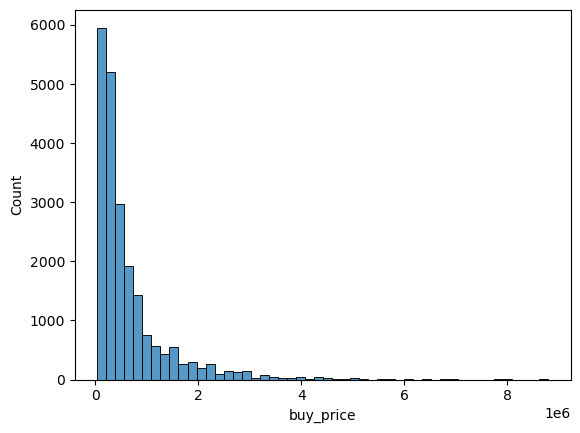

In [5]:
sb.histplot(df.buy_price, bins=50, kde=False)

Text(0, 0.5, 'Buy price')

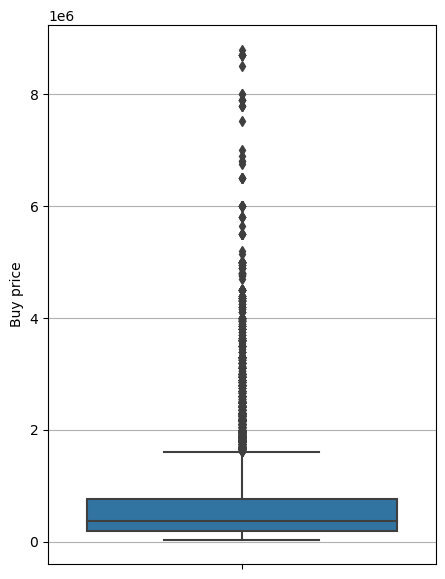

In [6]:
fig = plt.figure(figsize=(5, 7))
sb.boxplot(y=df.buy_price, data=df)
plt.grid(axis='y')
plt.ylabel('Buy price') 

In [7]:
# Виключемо дані, які знаходяться за межою 95го персентилю. 
q = df['buy_price'].quantile(0.95)
df = df[df['buy_price'] < q]

#### Візуалізація пропущених значень.

<AxesSubplot:>

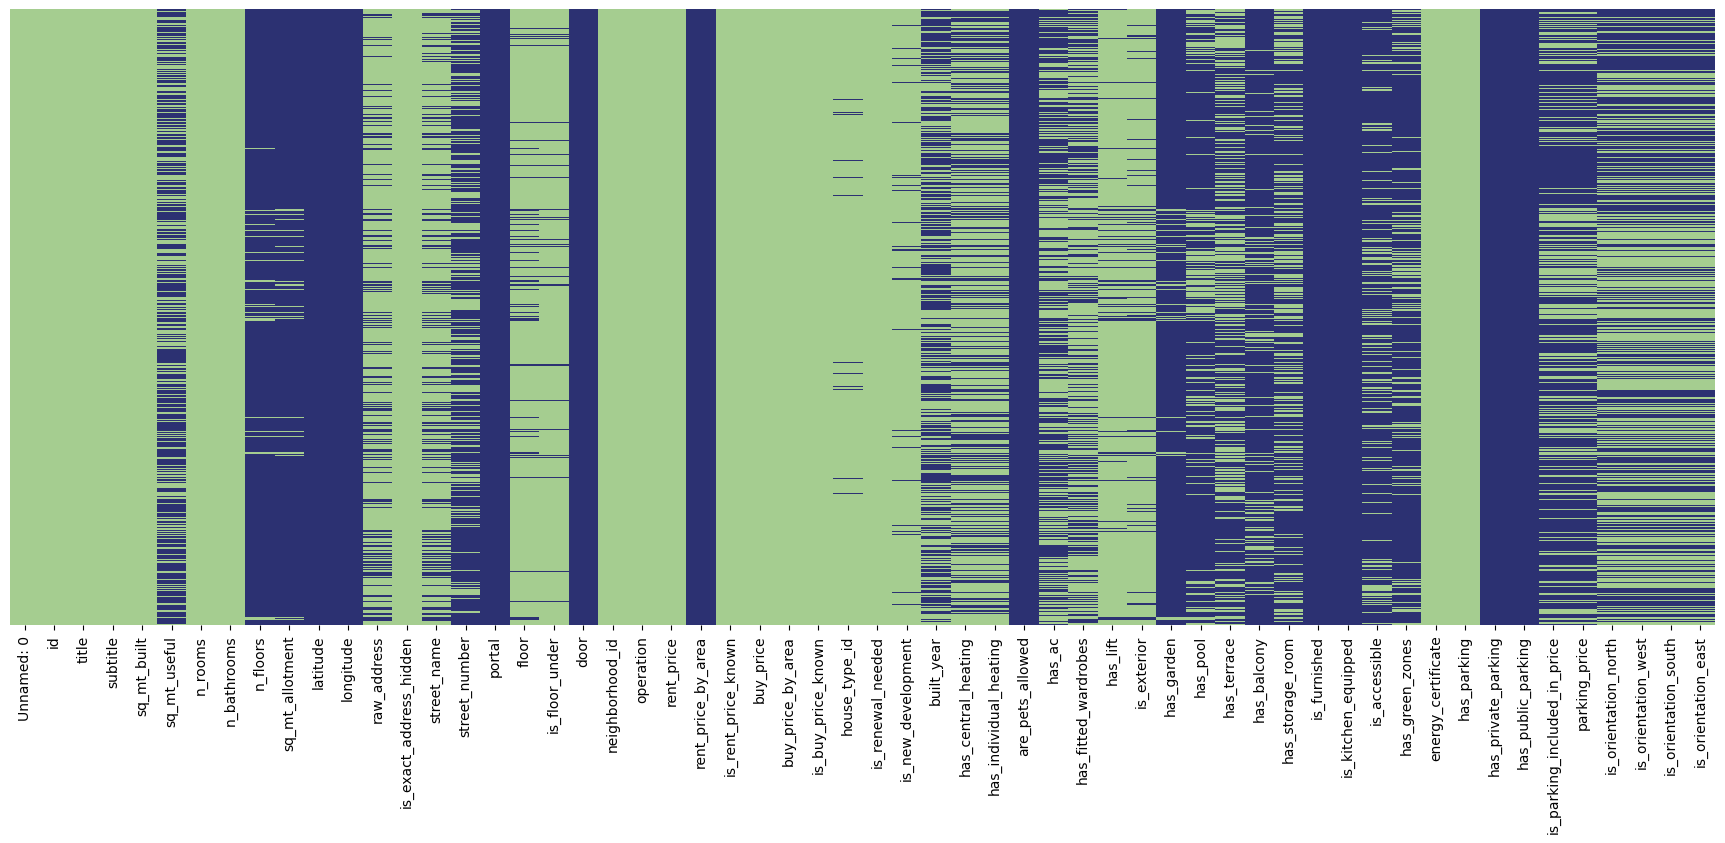

In [8]:
plt.figure(figsize=(22, 8))
sb.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='crest')

#### Первинне видалення даних.  
Видаляємо дані, які не впливають, або дуже незначно впливають на вартість нерухомості. Також ті дані, по яких великий відсоток пропущених значень.

In [9]:
df.columns

Index(['Unnamed: 0', 'id', 'title', 'subtitle', 'sq_mt_built', 'sq_mt_useful',
       'n_rooms', 'n_bathrooms', 'n_floors', 'sq_mt_allotment', 'latitude',
       'longitude', 'raw_address', 'is_exact_address_hidden', 'street_name',
       'street_number', 'portal', 'floor', 'is_floor_under', 'door',
       'neighborhood_id', 'operation', 'rent_price', 'rent_price_by_area',
       'is_rent_price_known', 'buy_price', 'buy_price_by_area',
       'is_buy_price_known', 'house_type_id', 'is_renewal_needed',
       'is_new_development', 'built_year', 'has_central_heating',
       'has_individual_heating', 'are_pets_allowed', 'has_ac',
       'has_fitted_wardrobes', 'has_lift', 'is_exterior', 'has_garden',
       'has_pool', 'has_terrace', 'has_balcony', 'has_storage_room',
       'is_furnished', 'is_kitchen_equipped', 'is_accessible',
       'has_green_zones', 'energy_certificate', 'has_parking',
       'has_private_parking', 'has_public_parking',
       'is_parking_included_in_price', 'parki

In [10]:
drop_columns = ['Unnamed: 0', 'id', 'title', 'latitude', 'longitude', 'n_floors', 'sq_mt_allotment','raw_address',
                'is_exact_address_hidden', 'street_name', 'street_number', 'portal','is_floor_under','door',
                'neighborhood_id', 'operation', 'rent_price', 'rent_price_by_area', 'is_rent_price_known',
                'is_buy_price_known', 'has_central_heating', 'has_individual_heating','are_pets_allowed',
                'has_lift', 'is_exterior', 'is_furnished', 'is_kitchen_equipped', 'is_accessible', 'energy_certificate',
                'has_private_parking', 'has_public_parking', 'is_parking_included_in_price', 'parking_price',
                'is_orientation_north','is_orientation_west', 'is_orientation_south', 'is_orientation_east']

In [11]:
df.drop(drop_columns, axis=1, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20587 entries, 0 to 21741
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subtitle              20587 non-null  object 
 1   sq_mt_built           20583 non-null  float64
 2   sq_mt_useful          8049 non-null   float64
 3   n_rooms               20587 non-null  int64  
 4   n_bathrooms           20572 non-null  float64
 5   floor                 18566 non-null  object 
 6   buy_price             20587 non-null  int64  
 7   buy_price_by_area     20587 non-null  int64  
 8   house_type_id         20198 non-null  object 
 9   is_renewal_needed     20587 non-null  bool   
 10  is_new_development    19629 non-null  object 
 11  built_year            9488 non-null   float64
 12  has_ac                10432 non-null  object 
 13  has_fitted_wardrobes  12612 non-null  object 
 14  has_garden            1060 non-null   object 
 15  has_pool           

In [13]:
df.to_csv('data/temp_data.csv', index=False)

In [14]:
data = pd.read_csv('data/temp_data.csv')
data.shape

(20587, 21)

### Відновлення втрачених даних і оцифровка логічних і категоріальних значень.

#### Значення True/Nan, True/False
Є певна кількість характеристик, які заповнені значеннями True або Nan. Ймовірно, в данному випадку Nan означає False, тобто відсутність даної ознаки у об'єкта. Тому для побудови математичної моделі оцифруємо такі значення, за схемою True : 1, Nan : 0. Також і звичайні булеві стовпчики True : 1, False : 0.

In [15]:
true_nan_col = ['has_ac','has_fitted_wardrobes', 'has_garden', 'has_pool', 'has_terrace', 'has_balcony',
                'has_green_zones','has_storage_room']

In [16]:
for col in true_nan_col:
    data[col] = np.where(data[col].isna(), 0, 1)

In [17]:
true_false_col = ['is_renewal_needed', 'has_parking']

In [18]:
for col in true_false_col:
    data[col] = np.where(data[col] == True, 1, 0)

#### Робота з серією sq_mt_built (загальна площа будівлі).  
Площа житла є одним з найвагоміших факторів, які впливають на ціну. Відновимо загальну площу, спираючись на дані по корисній площині. Ті записи, де немає даних ані з загальної площі, ані з корисної - видаляємо. Після заповнення даних загальної площі житла атрибут корисної площі видаляємо, оскільки ці дві характеристики дуже скорельовані.

In [19]:
min_useful_sq = 10
data = data[~(data.sq_mt_built.isna() & (data.sq_mt_useful.isna() | (data.sq_mt_useful <= min_useful_sq)))]

In [20]:
# коефіціент загальна площа / корисна площа
com_usf_sq = round(df.sq_mt_useful.mean()/df.sq_mt_built.mean(), 2)
print(com_usf_sq)

0.75


In [21]:
data.sq_mt_built.fillna(data.sq_mt_useful/com_usf_sq, inplace=True)

In [22]:
data.drop(['sq_mt_useful'], axis=1, inplace=True)

#### Дані щодо місцерозташування об'єктів нерухомості.  
Звісно, місцерозташування будинку сильно впливає на його ринкову вартість. В даному датасеті у двох стовпчиках представлена інформація щодо місцерозташування об'єктів: **title** (місцезнаходження об'єкту) i **subtitle** (район розташування об'єкту). Взагалі маємо 146 унікальних значень назв районів. Середня ціна за метр квадратний коливається від 1520 до 8320 євро в залежності від району. Тому призначимо районам вагові коефіціенти в новому стовпчику **distr_coef**, а текстові стовпчики прибираємо.

In [23]:
data.groupby('subtitle').agg({'buy_price_by_area' : 'mean'}).describe()

,buy_price_by_area
count,146.00
mean,3637.48
std,1350.72
min,1526.88
25%,2433.82
50%,3468.70
75%,4496.64
max,8327.33


In [24]:
data.subtitle.value_counts()

Chamartín, Madrid                           649
Moncloa, Madrid                             574
Centro, Madrid                              527
Chamberí, Madrid                            499
Hortaleza, Madrid                           393
                                           ... 
Barajas, Madrid                               7
Campo de las Naciones-Corralejos, Madrid      6
Casco Histórico de Barajas, Madrid            5
Timón, Madrid                                 4
Cuatro Vientos, Madrid                        2
Name: subtitle, Length: 146, dtype: int64

In [25]:
mean_by_distr = data.groupby('subtitle')['buy_price_by_area'].mean()
data['distr_coef'] = data.subtitle.apply(lambda x: mean_by_distr[x]/10000)

In [26]:
data.drop(['subtitle'], axis=1, inplace=True)

In [27]:
data.to_csv('data/temp_data.csv', index=False)

In [28]:
data = pd.read_csv('data/temp_data.csv')
data.shape

(20583, 20)

#### Заповнення пропущених значень по стовпчику **n_bathrooms** (кількість ваних або душевих у будинку) на підставі метражу приміщення.

In [29]:
data[['sq_mt_built', 'n_bathrooms']].describe().T

,count,mean,std,min,25%,50%,75%,max
sq_mt_built,20583.0,128.66,99.12,13.0,70.0,96.0,148.0,998.0
n_bathrooms,20568.0,1.91,1.14,1.0,1.0,2.0,2.0,14.0


In [30]:
def fill_bath(sq_mt):
    if sq_mt < 80:
        return 1
    elif sq_mt < 200:
        return 2
    elif sq_mt < 300:
        return 3
    elif sq_mt < 1000:
        return 4
    else:
        return 5

In [31]:
data['n_bathrooms'] = data['n_bathrooms'].fillna(df.sq_mt_built.apply(fill_bath))  

#### Приведення до числових значень характеристики  floor (поверх).  
Поверх розташування має певний вплив на ціну нерухомості. Тому нецифровим категоріям (напівпідвал, цоколь, мезонин тощо ) призначимо цифрове значення поверху відповідно ціни квадратного метру. Умовно розіб'ємо нецифрові категорії на 3 групи: 
* 'Sótano exterior', 'Entreplanta interior' призначаємо значення 5;
* 'Sótano interior', 'Semi-sótano interior'  3; 
* найдешевша група отримує значення 0.   

Значення медіанних цін в залежності від поверху представлені у таблиці нижче:

In [32]:
df_floor = data.groupby(['floor'])['buy_price_by_area'].agg(['median', 'count'])
df_floor.sort_values(by=['median'], ascending=False)

,median,count
floor,,
Sótano exterior,4307.5,4
6,4300.0,861
Entreplanta interior,4235.5,32
7,4200.0,535
5,4187.0,1240
8,4053.0,313
4,3860.0,2215
9,3838.5,180
1,3803.0,4367


In [33]:
def fill_floor(floor):
   
    if floor in ['Sótano exterior', 'Entreplanta interior']:
        return 5
    elif floor in ['Sótano interior', 'Semi-sótano interior']:
        return 3
    elif floor in ['Bajo', 'Semi-sótano exterior','Sótano', 'Semi-sótano','Entreplanta exterior', 'Entreplanta']:
        return 0
    else:
        return float(floor)

data['floor'] = data['floor'].apply(fill_floor)     

In [34]:
data.groupby(['floor'])['buy_price_by_area'].agg('median').median()

3849.25

In [35]:
# медіанна ціна 1 м.кв. приблизно віповідає 4-му поверху, тому відсутні значення поверху житла заповнимо саме 4.
data.floor.fillna(4.0, inplace=True)

#### Ознака house_type_id (тип житла).
Оскільки переважна більшість житлових об'єктів знаходяться у багатоповерхових будинках (значення **HouseType 1: Pisos**), заповнимо відсутні дані саме цим значенням.Тоді оцифруємо цю ознаку, згідно ранжованого за ціною розташування значень.

In [36]:
df_ht = data.groupby(['house_type_id'])['buy_price_by_area'].agg(['median', 'count'])
df_ht.sort_values(by=['median']).reset_index()

,house_type_id,median,count
0,HouseType 2: Casa o chalet,3107.0,1366
1,HouseType 1: Pisos,3629.0,17222
2,HouseType 4: Dúplex,3699.0,631
3,HouseType 5: Áticos,4552.0,975


In [37]:
data.house_type_id.mode()[0]

'HouseType 1: Pisos'

In [38]:
data.house_type_id.fillna(data.house_type_id.mode()[0], inplace=True)

In [39]:
def fill_house_type(h_type):
    dc = {'HouseType 2: Casa o chalet': 0,
          'HouseType 1: Pisos': 1,
          'HouseType 4: Dúplex' : 2,
          'HouseType 5: Áticos': 3}
    return dc[h_type]

data['house_type_id'] = data['house_type_id'].apply(fill_house_type)
data = data.astype({'house_type_id': 'int16'})

In [40]:
data.to_csv('data/temp_data.csv', index=False)

In [41]:
data = pd.read_csv('data/temp_data.csv')

#### Ознаки built_year та is_new_development (Рік побудови, Чи нова побудова)  
По стовпчику **built_year** відсутні більше половини значень, але рік побудови є впливовим фактором на вартість житла. Щоб не втратити важливі дані, ті записи, які мають позитивну (True) ознаку **is_new_development** (новобудова) заповнимо 2022 роком, всі інші - медіанним значення року побудови. Після цього стовпчик **is_new_development** видаляємо.

In [42]:
data.built_year.describe()

count    9485.00
mean     1969.96
std        70.85
min      1723.00
25%      1957.00
50%      1970.00
75%      1994.00
max      8170.00
Name: built_year, dtype: float64

In [43]:
data.built_year[data.built_year == 8170]

18282    8170.0
Name: built_year, dtype: float64

In [44]:
# видалення явно помилкового значення року побудови
data.at[19121, 'built_year'] = np.nan

In [45]:
data[['is_new_development', 'built_year']][data.is_new_development == True]

,is_new_development,built_year
42,True,NaN
43,True,NaN
57,True,NaN
58,True,NaN
59,True,NaN
...,...,...
20155,True,NaN
20156,True,NaN
20157,True,NaN
20170,True,NaN


In [46]:
data.is_new_development.value_counts()

False    18180
True      1445
Name: is_new_development, dtype: int64

In [47]:
median_year = data.built_year.median()
max_year = data.built_year.max()

In [48]:
data.loc[data.is_new_development == True, 'built_year'] = data.built_year.fillna(max_year)
data.built_year.fillna(median_year, inplace=True)

In [49]:
data.drop('is_new_development', axis=1, inplace=True)

In [50]:
data.to_csv('data/temp_data.csv', index=False)

In [51]:
data = pd.read_csv('data/temp_data.csv')

#### Візуалізація цілосності данних.

<AxesSubplot:>

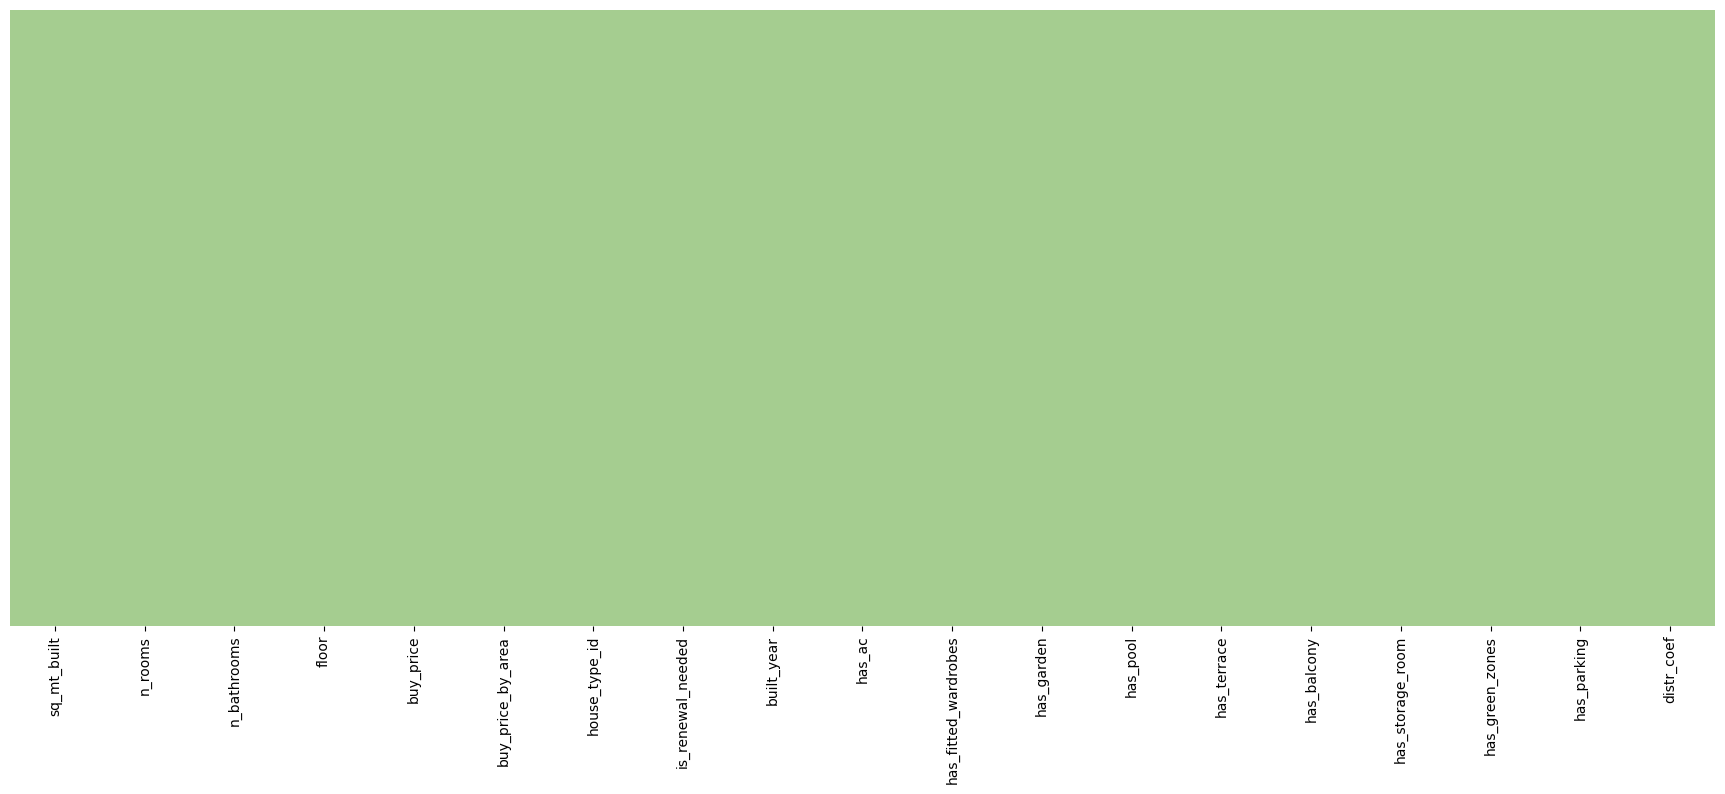

In [52]:
plt.figure(figsize=(22, 8))
sb.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='crest')

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20583 entries, 0 to 20582
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sq_mt_built           20583 non-null  float64
 1   n_rooms               20583 non-null  int64  
 2   n_bathrooms           20582 non-null  float64
 3   floor                 20583 non-null  float64
 4   buy_price             20583 non-null  int64  
 5   buy_price_by_area     20583 non-null  int64  
 6   house_type_id         20583 non-null  int64  
 7   is_renewal_needed     20583 non-null  int64  
 8   built_year            20583 non-null  float64
 9   has_ac                20583 non-null  int64  
 10  has_fitted_wardrobes  20583 non-null  int64  
 11  has_garden            20583 non-null  int64  
 12  has_pool              20583 non-null  int64  
 13  has_terrace           20583 non-null  int64  
 14  has_balcony           20583 non-null  int64  
 15  has_storage_room   

#### Теплова карта матриці кореляції по признаках, які вдалося відновити.

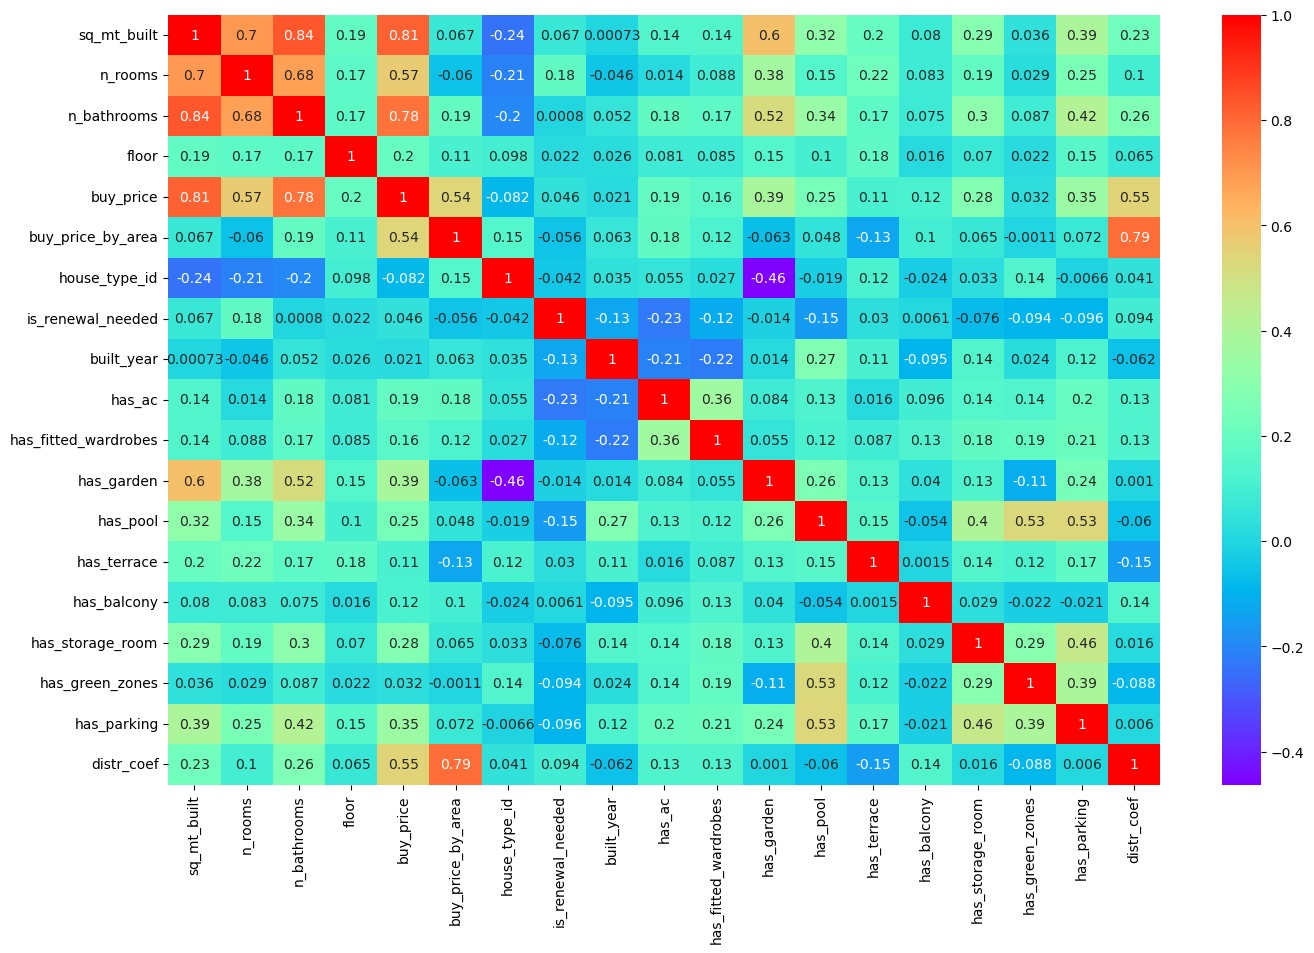

In [54]:
plt.figure(figsize=(16,10))
sb.heatmap(data.corr(),annot=True,cmap='rainbow')
plt.show()

In [55]:
data.corr()['buy_price'].sort_values(ascending=False)

buy_price               1.00
sq_mt_built             0.81
n_bathrooms             0.78
n_rooms                 0.57
distr_coef              0.55
buy_price_by_area       0.54
has_garden              0.39
has_parking             0.35
has_storage_room        0.28
has_pool                0.25
floor                   0.20
has_ac                  0.19
has_fitted_wardrobes    0.16
has_balcony             0.12
has_terrace             0.11
is_renewal_needed       0.05
has_green_zones         0.03
built_year              0.02
house_type_id          -0.08
Name: buy_price, dtype: float64

Цільова ознака **buy_price** має високу кореляцію з характеристиками **sq_mt_built** i **n_bathrooms**, середню кореляцію з признаками **n_rooms, buy_price_by_area, has_garden, has_parcking** та **distr_coef**. З рештою ознак кореляція слабка, або відсутня.   

Також бачимо, що ознаки **sq_mt_built, n_rooms** i **n_bathrooms** скорельовані між собою, що цілком логічно: чим більше житлове приміщення тим більше в ньому кімнат і санвузлів.

Ознаки **has_parking, has_green_zone, has_pool, has_storage_room** теж мають деяку кореляцію між собою. Скоріш за все, всі ці ознаки переважно відносяться до приватних будинків.

Тому, щоб уникнути проблеми колінеарності видалимо ознаки **n_rooms, n_bathrooms** і **has_pool**.   

Також видалимо ознаку **buy_price_by_area** тому що це технічний показник, який є відношенням вартості об'єкту до його площи.

In [56]:
drop_columns = ['n_rooms', 'n_bathrooms', 'buy_price_by_area', 'has_pool']
data.drop(columns=drop_columns, axis=1, inplace=True)

In [57]:
data.to_csv('data/clean_data.csv', index=False)